# Computing the timing and Pareto front across coordination algorithms


Calculate the time taken to perform the MaterialsCoord benchmark and use the errors to plot a Pareto front.

First load the Benchmark object and load all test structures.

In [34]:
import numpy as np
import pandas as pd

from pymatgen.analysis.local_env import BrunnerNN_reciprocal, EconNN, JmolNN, \
                                        MinimumDistanceNN, MinimumOKeeffeNN, MinimumVIRENN, \
                                        VoronoiNN, VoronoiNN_modified, CrystalNN
from materialscoord.core import Benchmark, HumanInterpreter

from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

methods = [BrunnerNN_reciprocal(), EconNN(), JmolNN(), CrystalNN(), VoronoiNN(tol=0.5),
           MinimumDistanceNN(), MinimumOKeeffeNN(), MinimumVIRENN(),
           HumanInterpreter()]
structure_groups = ["common_binaries", "elemental", "A2BX4", "ABX3", "ABX4"]

algos = ["BrunnerNN_reciprocal", "EconNN", "JmolNN", "CrystalNN", "VoronoiNN",
         "MinimumDistanceNN", "MinimumOKeeffeNN", "MinimumVIRENN"]


preset = Benchmark.from_preset(preset_name=structure_groups)

structures = list(preset.test_structures.values())
all_sites = [
    [structure.index(x[0]) for x in SpacegroupAnalyzer(
        structure).get_symmetrized_structure().equivalent_sites]
    for structure in structures]

Define a minimal function to time the Benchmark. Similar to how the scores are calculated, we only calculate the coordination environment for symmetry inequivalent sites.

In [37]:
import time

def time_nn(nn):
    t0 = time.perf_counter()
    
    for sites, structure in zip(all_sites, structures):
        for i in sites:
            nn.get_cn_dict(structure, i)
    
    return time.perf_counter() - t0

Calculate the timings for each algorithm.

In [ ]:
import numpy as np

scores = []
n_repeat = 1

for nn in methods[-1:]:
    method_scores = [time_nn(nn) for _ in range(n_repeat)]       
    scores.append(np.mean(method_scores))

Calculate the benchmark scores for each algorithm.

In [ ]:
preset.benchmark(methods=methods)
df = preset.score(methods)
errors = df.loc["Total"].values

Define a function to calculate the Pareto front.

In [51]:
def pareto_frontier(x, y, maximize_x=False, maximize_y=False):    
    sort = sorted([[x[i], y[i]] for i in range(len(x))], reverse=maximize_x)
    
    # Start the Pareto frontier with the first value in the sorted list
    p_front = [sort[0]]
    
    # Loop through the sorted list
    for pair in sort[1:]:
        if maximize_y: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
                
    # Turn resulting pairs back into a list of Xs and Ys
    p_front_x = [pair[0] for pair in p_front]
    p_front_y = [pair[1] for pair in p_front]
    return p_front_x, p_front_y

Plot the results.

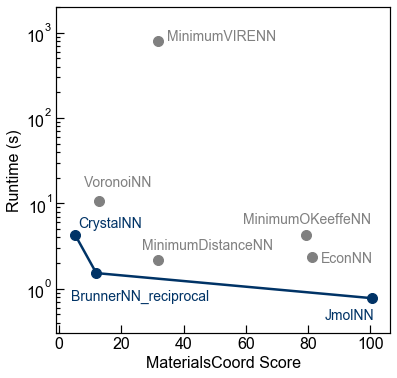

In [188]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

p_front = pareto_frontier(errors, scores)

# define matplotlib style settings
style = {
    "font.sans-serif": ["Helvetica", "Arial"],
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.major.size": 8,
    "ytick.minor.size": 4,  
    "lines.linewidth": 2.5,
    "lines.markersize": 10,
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.2,
    "xtick.minor.width": 1.2,
    "ytick.major.width": 1.2,
    "ytick.minor.width": 1.2,  
}

# use these shifts to fine tune the positions of the labels
shifts = {
    "BrunnerNN_reciprocal": {"x": -8, "y": -0.8}, 
    "EconNN": {"x": 3, "y": -0.3},
    "JmolNN": {"x": -15, "y": -0.35},
    "CrystalNN": {"x": 1, "y": 1},
    "VoronoiNN": {"x": -5, "y": 5},
    "MinimumDistanceNN": {"x": -5, "y": 0.7},
    "MinimumOKeeffeNN": {"x": -20, "y": 1.5},
    "MinimumVIRENN": {"x": 3, "y": 10},
}

highlight = "#003366"

plt.style.use(style)
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

for algo, (x, y) in zip(algos, zip(errors, scores)):
    xshift = shifts[algo]["x"]
    yshift = shifts[algo]["y"]
    
    # color the points depending on whether 
    on_front = x in p_front[0] and y in p_front[1]
    color = highlight if on_front else "gray" 
    
    ax.scatter(x, y, c=color)
    plt.text(x + xshift, y + yshift, algo, fontsize=14, color=color)

# plot the Pareto front line
ax.plot(p_front[0], p_front[1], zorder=-1, color=highlight)

ax.set_ylim((0.3, 2e3))
ax.set(xlabel="MaterialsCoord Score", ylabel="Runtime (s)")
ax.semilogy()

plt.savefig(os.path.join("keep", "Pareto_timing.png"),
            dpi=400, bbox_inches="tight")
plt.show()
